In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from tqdm.notebook import tqdm
sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from config import *
from models.nt_classifier import build as build_model 
from util.plot_utils import balance_df, obtain_plot, plot_logs, plot_roc_curves
from util.plot_utils import collect_results_based_on_confidence_level_based_on_percentile as collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
checkpoint_dir_paths = []

chkpt_folder = os.path.join(ROOT_DIR, 'checkpoints')

models_to_check = os.listdir(chkpt_folder)
for model_name in models_to_check:
    model_folder = os.path.join(chkpt_folder, model_name)
    test_paris = os.path.join(chkpt_folder, model_name, 'test_results500.csv')
    ricseq = os.path.join(chkpt_folder, model_name, 'ricseq_results500.csv')
    splash = os.path.join(chkpt_folder, model_name, 'splash_results500.csv')
    if os.path.exists(test_paris) & os.path.exists(ricseq) & os.path.exists(splash) :
        checkpoint_dir_paths.append(model_folder)

In [4]:
def obtain_auc_nt_intarna(res):
    fpr, tpr, _ = roc_curve(res.ground_truth, res.probability)
    roc_auc_nt = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(res.ground_truth, abs(res.E_norm))
    roc_auc_intarna = auc(fpr, tpr)
    return roc_auc_nt, roc_auc_intarna

In [5]:
def load_results(checkpoint_dir_paths, space, n_values, MIN_PERC, only_test, chkpt_folder):
    
    filename_output = os.path.join(chkpt_folder, 'model_performance.pkl')
    
    if os.path.exists(filename_output):
        # Loading the variables from the file
        with open(filename_output, 'rb') as file:
            df_full, name_map, confidence_level = pickle.load(file)
        
        to_do = list( set(checkpoint_dir_paths) - set(name_map.values()) )
        
        if len(to_do) > 0:
        
            new_df_full, new_name_map, new_confidence_level = otain_results(to_do, space, n_values, MIN_PERC, only_test, index_name = len(name_map))

            df_full = pd.concat([df_full,new_df_full], axis = 0).reset_index(drop = True)
            name_map.update(new_name_map)

            # Saving the variables to a file
            with open(filename_output, 'wb') as file:
                pickle.dump((df_full, name_map, confidence_level), file)

    else:
        df_full, name_map, confidence_level = otain_results(checkpoint_dir_paths, space, n_values, MIN_PERC, only_test)
        # Saving the variables to a file
        with open(filename_output, 'wb') as file:
            pickle.dump((df_full, name_map, confidence_level), file)
        
    return df_full, name_map, confidence_level

In [6]:
def otain_results(checkpoint_dir_paths, space, n_values, MIN_PERC, only_test, index_name = 0):

    diz_results = {}
    name_map = {}
    
    

    for _, checkpoint_dir in tqdm(enumerate(checkpoint_dir_paths), total = len(checkpoint_dir_paths)):
        row = {}

        # -------------- -------------- -------------- --------------
        #                            PARIS
        # -------------- -------------- -------------- --------------

        HOW = 'test'
        SPECIE = 'human'

        # -------------- -------------- -------------- --------------

        file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training.txt")
        with open(file_train, "rb") as fp:   # Unpickling
            gene_pairs_train_original = pickle.load(fp)

        file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt_HQ.txt")
        with open(file_train, "rb") as fp:   # Unpickling
            gene_pairs_train = pickle.load(fp)

        file_test = os.path.join(rna_rna_files_dir, f"gene_pairs_{HOW}_nt_HQ.txt")
        with open(file_test, "rb") as fp:   # Unpickling
            gene_pairs_test = pickle.load(fp)

        #-------------- -------------- -------------- --------------

        test500 = pd.read_csv(os.path.join(metadata_dir, f'{HOW}500.csv'))
        assert test500.couples.isin(gene_pairs_test).all()

        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))

        assert test500.shape[0] == df_nt[['couples', 'interacting', 'policy']].merge(test500, on = 'couples').shape[0]
        test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex']].merge(test500, on = 'couples')

        id_cds_cds = set(test500[test500['where'] == 'CDS-CDS'].couples)

        #-------------- -------------- -------------- --------------

        res = pd.read_csv(os.path.join(checkpoint_dir, f'{HOW}_results500.csv'))
        # Drop all the pairs (they should be 60-70) that are present in the training set.
        res = res[~res.couples.isin(gene_pairs_train_original)]
        # show only results for 1 specie
        res = res[res.specie == SPECIE]

        intarna = pd.read_csv(os.path.join(intarna_dir, f'{HOW}500', f'{HOW}.csv'), sep = ';')
        intarna['key'] = intarna.id1 + '_' + intarna.id2

        # keep only the lower E_norm for each group
        intarna.sort_values('E_norm', ascending = False, inplace=True)
        intarna.drop_duplicates(subset='key', keep='first', inplace=True)
        intarna = intarna.reset_index(drop = True)
        intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
        intarna['couples'] = intarna['couples'].astype(int)
        intarna = intarna.dropna()

        res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

        # -------------- -------------- -------------- --------------

        subset_test_nt_sampled = os.path.join(rna_rna_files_dir, f"gene_pairs_{HOW}_sampled_nt_HQ.txt")
        with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
            subset_test_nt_sampled = pickle.load(fp)

        easypos_smartneg_sampled = res[res.id_sample.isin(subset_test_nt_sampled)]
        easypos_smartneg_sampled = balance_df(easypos_smartneg_sampled)

        row['paris_acc_ES_sampled'] = (easypos_smartneg_sampled.prediction == easypos_smartneg_sampled.ground_truth).sum()/easypos_smartneg_sampled.shape[0]
        row['paris_auc_ES_sampled'], row['paris_aucINTARNA_ES_sampled'] = obtain_auc_nt_intarna(easypos_smartneg_sampled)

        # -------------- -------------- -------------- --------------

        subset_test_nt_sampled = os.path.join(rna_rna_files_dir, f"gene_pairs_{HOW}_HQ.txt")
        with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
            subset_test_nt_sampled = pickle.load(fp)

        all_val = res[res.couples.isin(subset_test_nt_sampled)]
        assert all_val.shape[0] == res.shape[0]
        easypos_smartneg = all_val[all_val.policy.isin(['smartneg', 'easypos'])]

        easypos_smartneg_balanced = balance_df(easypos_smartneg)

        row['paris_acc_ES'] = (easypos_smartneg_balanced.prediction == easypos_smartneg_balanced.ground_truth).sum()/easypos_smartneg_balanced.shape[0]
        row['paris_auc_ES'], row['paris_aucINTARNA_ES']  = obtain_auc_nt_intarna(easypos_smartneg_balanced)

        # -------------- -------------- -------------- --------------

        easypos_smartneg_balanced = balance_df(easypos_smartneg[easypos_smartneg.id_sample.isin(id_cds_cds)])

        row['paris_acc_ES_cdscds'] = (easypos_smartneg_balanced.prediction == easypos_smartneg_balanced.ground_truth).sum()/easypos_smartneg_balanced.shape[0]
        row['paris_auc_ES_cdscds'], row['paris_aucINTARNA_ES_cdscds'] = obtain_auc_nt_intarna(easypos_smartneg_balanced)

        # -------------- -------------- -------------- --------------

        easypos_smartneg_balanced = balance_df(easypos_smartneg[~easypos_smartneg.id_sample.isin(id_cds_cds)])

        row['paris_acc_ES_nocdscds'] = (easypos_smartneg_balanced.prediction == easypos_smartneg_balanced.ground_truth).sum()/easypos_smartneg_balanced.shape[0]
        row['paris_auc_ES_nocdscds'], row['paris_aucINTARNA_ES_nocdscds'] = obtain_auc_nt_intarna(easypos_smartneg_balanced)

        # -------------- -------------- -------------- --------------

        HQ_TRESHOLD = 35

        subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >HQ_TRESHOLD) & (abs(test500.seed_y1 - test500.seed_y2) > HQ_TRESHOLD) ]
        easypos_smartneg_HQ = easypos_smartneg[easypos_smartneg.id_sample.isin(subset.couples)]

        assert set(easypos_smartneg_HQ.policy.value_counts().index) == set(['smartneg', 'easypos'])

        easypos_smartneg_HQ_balanced = balance_df(easypos_smartneg_HQ)

        row['paris_acc_ES_HQ'] = (easypos_smartneg_HQ_balanced.prediction == easypos_smartneg_HQ_balanced.ground_truth).sum()/easypos_smartneg_HQ_balanced.shape[0]
        row['paris_auc_ES_HQ'], row['paris_aucINTARNA_ES_HQ'] = obtain_auc_nt_intarna(easypos_smartneg_HQ_balanced)

        # -------------- -------------- -------------- --------------

        ep = easypos_smartneg_balanced[(easypos_smartneg_balanced.policy == 'easypos')]
        row['paris_acc_easypos'] = ep[ep.ground_truth == ep.prediction].shape[0]/ep.shape[0]

        sn = easypos_smartneg_balanced[(easypos_smartneg_balanced.policy == 'smartneg')]
        row['paris_acc_smartneg'] = sn[sn.ground_truth == sn.prediction].shape[0]/sn.shape[0]

        hn = res[(res.policy == 'hardneg')]
        row['paris_acc_hardneg'] = hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0]

        easy = res[(res.policy == 'easyneg')]
        row['paris_acc_easyneg'] = easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0]

        # -------------- -------------- -------------- --------------

        ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

        ephnen_sampled = balance_df(ephnen)

        row['paris_acc_EPENHN'] = ephnen_sampled[ephnen_sampled.ground_truth == ephnen_sampled.prediction].shape[0]/ephnen_sampled.shape[0]
        row['paris_auc_EPENHN'], row['paris_aucINTARNA_EPENHN'] = obtain_auc_nt_intarna(ephnen_sampled)

        # -------------- -------------- -------------- --------------

        poshq = set(easypos_smartneg_HQ[easypos_smartneg_HQ.ground_truth == 1].id_sample)
        ephnen = res[(res.policy == 'easyneg')|(res.id_sample.isin(poshq))|(res.policy == 'hardneg')]

        ephnen_sampled = balance_df(ephnen)

        row['paris_acc_EPENHN_HQ'] = ephnen_sampled[ephnen_sampled.ground_truth == ephnen_sampled.prediction].shape[0]/ephnen_sampled.shape[0]
        row['paris_auc_EPENHN_HQ'], row['paris_aucINTARNA_EPENHN_HQ'] = obtain_auc_nt_intarna(ephnen_sampled)

        # -------------- -------------- -------------- --------------

        df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))
        regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
        df_train = regex
        df_train['g1'] = regex[0]
        df_train['g2'] = regex[1]
        df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

        not_in_train = res[~(res.gene1_original.isin(df_train_genes) & res.gene2_original.isin(df_train_genes))]
        not_in_train_epsn = not_in_train[(not_in_train.policy == 'easypos')|(not_in_train.policy == 'smartneg')]
        not_in_train_epsn_balanced = balance_df(not_in_train_epsn)

        row['paris_acc_ES_notrain'] = not_in_train_epsn_balanced[not_in_train_epsn_balanced.ground_truth == not_in_train_epsn_balanced.prediction].shape[0]/not_in_train_epsn_balanced.shape[0]
        row['paris_auc_ES_notrain'], row['paris_aucINTARNA_ES_notrain'] = obtain_auc_nt_intarna(not_in_train_epsn_balanced)

        # -------------- -------------- -------------- --------------


        confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'intarna', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = space, calc_ens = False)

        for i in range(len(confidence_level)):
            row[f'paris_ES_INTARNAconf{confidence_level[i]}'] = auc_nt[i]
            row[f'paris_ES_INTARNA_INTARNAconf{confidence_level[i]}'] = auc_intarna[i]

        confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'nt', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = space, calc_ens = False)

        for i in range(len(confidence_level)):
            row[f'paris_ES_NTconf{confidence_level[i]}'] = auc_nt[i]
            row[f'paris_ES_INTARNA_NTconf{confidence_level[i]}'] = auc_intarna[i]


        # -------------- -------------- -------------- --------------
        #                       RICSEQ and SPLASH
        # -------------- -------------- -------------- --------------

        exclude_train_genes = False
        MIN_N_READS_RICSEQ = 3

        for how in ['ricseq', 'splash']:

            res = pd.read_csv(os.path.join(checkpoint_dir, f'{how}_results500.csv'))

            file_train = os.path.join(rna_rna_files_dir, f'{how}', 'gene_pairs_training.txt')
            with open(file_train, "rb") as fp:   # Unpickling
                train_couples = pickle.load(fp)

            file_test = os.path.join(rna_rna_files_dir, f'{how}', 'gene_pairs_test.txt')
            with open(file_test, "rb") as fp:   # Unpickling
                test_couples = pickle.load(fp)

            tr_genes=pd.Series(train_couples).str.extractall('(.*)_(.*)').reset_index()
            training_genes = set(tr_genes[0]).union(tr_genes[1])

            if only_test:
                res = res[res.couples.isin(test_couples)]
                if exclude_train_genes:
                    res = res[~(res.gene1_original.isin(training_genes)) & (res.gene2_original.isin(training_genes))]


            test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))
            df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))

            assert test500.shape[0] == df_nt[['couples', 'interacting', 'policy']].merge(test500, on = 'couples').shape[0]

            if how == 'ricseq':
                test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex', 'n_reads']].merge(test500, on = 'couples')
                ids_to_keep = set(test500[test500.n_reads >= MIN_N_READS_RICSEQ].couples).union(test500[test500.interacting==False].couples)
                res = res[res.id_sample.isin(ids_to_keep)]
            elif how == 'mario':
                test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex', 'n_reads']].merge(test500, on = 'couples')
            elif how == 'splash':
                test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'experiment']].merge(test500, on = 'couples')
            else:
                raise NotImplementedError

            id_cds_cds = set(test500[test500['where'] == 'CDS-CDS'].couples)


            intarna = pd.read_csv(os.path.join(intarna_dir, f'{how}500_RANDOM', f'{how}.csv'), sep = ';')
            intarna['key'] = intarna.id1 + '_' + intarna.id2

            # keep only the lower E_norm for each group
            intarna.sort_values('E_norm', ascending = False, inplace=True)
            intarna.drop_duplicates(subset='key', keep='first', inplace=True)
            intarna = intarna.reset_index(drop = True)
            intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
            intarna['couples'] = intarna['couples'].astype(int)

            intarna = intarna.dropna()
            res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

            # -------------- -------------- -------------- --------------

            easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])]
            balanced_epsn = balance_df(easypos_smartneg)

            row[f'{how}_acc_ES'] = (balanced_epsn.prediction == balanced_epsn.ground_truth).sum()/balanced_epsn.shape[0]
            row[f'{how}_auc_ES'], row[f'{how}_aucINTARNA_ES'] = obtain_auc_nt_intarna(balanced_epsn)

            # -------------- -------------- -------------- --------------

            easypos_smartneg_balanced = balance_df(easypos_smartneg[easypos_smartneg.id_sample.isin(id_cds_cds)])
            row[f'{how}_acc_ES_cdscds'] = (easypos_smartneg_balanced.prediction == easypos_smartneg_balanced.ground_truth).sum()/easypos_smartneg_balanced.shape[0]
            row[f'{how}_auc_ES_cdscds'], row[f'{how}_aucINTARNA_ES_cdscds'] = obtain_auc_nt_intarna(easypos_smartneg_balanced)

            # -------------- -------------- -------------- --------------

            easypos_smartneg_balanced = balance_df(easypos_smartneg[~easypos_smartneg.id_sample.isin(id_cds_cds)])

            row[f'{how}_acc_ES_nocdscds'] = (easypos_smartneg_balanced.prediction == easypos_smartneg_balanced.ground_truth).sum()/easypos_smartneg_balanced.shape[0]
            row[f'{how}_auc_ES_nocdscds'], row[f'{how}_aucINTARNA_ES_nocdscds'] = obtain_auc_nt_intarna(easypos_smartneg_balanced)

            # -------------- -------------- -------------- --------------

            ep = balanced_epsn[(balanced_epsn.policy == 'easypos')]
            row[f'{how}_acc_easypos'] = ep[ep.ground_truth == ep.prediction].shape[0]/ep.shape[0]

            sn = balanced_epsn[(balanced_epsn.policy == 'smartneg')]
            row[f'{how}_acc_smartneg'] = sn[sn.ground_truth == sn.prediction].shape[0]/sn.shape[0]

            hn = res[(res.policy == 'hardneg')]
            row[f'{how}_acc_hardneg'] = hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0]

            easy = res[(res.policy == 'easyneg')]
            row[f'{how}_acc_easyneg'] = easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0]

            # -------------- -------------- -------------- --------------

            ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

            ephnen_sampled = balance_df(ephnen)
            row[f'{how}_acc_EPENHN'] = ephnen_sampled[ephnen_sampled.ground_truth == ephnen_sampled.prediction].shape[0]/ephnen_sampled.shape[0]
            row[f'{how}_auc_EPENHN'], row[f'{how}_aucINTARNA_EPENHN'] = obtain_auc_nt_intarna(ephnen_sampled)


            # -------------- -------------- -------------- --------------

            confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'intarna', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = space, calc_ens = False)

            for i in range(len(confidence_level)):
                row[f'{how}_ES_INTARNAconf{confidence_level[i]}'] = auc_nt[i]
                row[f'{how}_ES_INTARNA_INTARNAconf{confidence_level[i]}'] = auc_intarna[i]

            confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'nt', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = space, calc_ens = False)

            for i in range(len(confidence_level)):
                row[f'{how}_ES_NTconf{confidence_level[i]}'] = auc_nt[i]
                row[f'{how}_ES_INTARNA_NTconf{confidence_level[i]}'] = auc_intarna[i]

        # -------------- -------------- -------------- --------------
        #                 RICSEQ and SPLASH not in train
        # -------------- -------------- -------------- --------------

        exclude_train_genes = True
        MIN_N_READS_RICSEQ = 3

        for how in ['ricseq', 'splash']:

            res = pd.read_csv(os.path.join(checkpoint_dir, f'{how}_results500.csv'))

            file_train = os.path.join(rna_rna_files_dir, f'{how}', 'gene_pairs_training.txt')
            with open(file_train, "rb") as fp:   # Unpickling
                train_couples = pickle.load(fp)

            file_test = os.path.join(rna_rna_files_dir, f'{how}', 'gene_pairs_test.txt')
            with open(file_test, "rb") as fp:   # Unpickling
                test_couples = pickle.load(fp)

            tr_genes=pd.Series(train_couples).str.extractall('(.*)_(.*)').reset_index()
            training_genes = set(tr_genes[0]).union(tr_genes[1])

            if only_test:
                res = res[res.couples.isin(test_couples)]
                if exclude_train_genes:
                    res = res[~(res.gene1_original.isin(training_genes)) & (res.gene2_original.isin(training_genes))]


            test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))
            df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))

            assert test500.shape[0] == df_nt[['couples', 'interacting', 'policy']].merge(test500, on = 'couples').shape[0]

            if how == 'ricseq':
                test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex', 'n_reads']].merge(test500, on = 'couples')
                ids_to_keep = set(test500[test500.n_reads >= MIN_N_READS_RICSEQ].couples).union(test500[test500.interacting==False].couples)
                res = res[res.id_sample.isin(ids_to_keep)]
            elif how == 'mario':
                test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex', 'n_reads']].merge(test500, on = 'couples')
            elif how == 'splash':
                test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'experiment']].merge(test500, on = 'couples')
            else:
                raise NotImplementedError

            id_cds_cds = set(test500[test500['where'] == 'CDS-CDS'].couples)


            intarna = pd.read_csv(os.path.join(intarna_dir, f'{how}500_RANDOM', f'{how}.csv'), sep = ';')
            intarna['key'] = intarna.id1 + '_' + intarna.id2

            # keep only the lower E_norm for each group
            intarna.sort_values('E_norm', ascending = False, inplace=True)
            intarna.drop_duplicates(subset='key', keep='first', inplace=True)
            intarna = intarna.reset_index(drop = True)
            intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
            intarna['couples'] = intarna['couples'].astype(int)

            intarna = intarna.dropna()
            res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

            # -------------- -------------- -------------- --------------

            easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])]
            balanced_epsn = balance_df(easypos_smartneg)

            row[f'{how}_acc_ES_notrain'] = (balanced_epsn.prediction == balanced_epsn.ground_truth).sum()/balanced_epsn.shape[0]
            row[f'{how}_auc_ES_notrain'], row[f'{how}_aucINTARNA_ES_notrain'] = obtain_auc_nt_intarna(balanced_epsn)

        model_name = f'model{_ + index_name}'
        name_map[model_name] = checkpoint_dir
        diz_results[model_name] = row
    
    df = pd.DataFrame.from_dict(diz_results, 'index')
    df = df*100
    df = df.round(2)
    df = df.reset_index().rename({'index':'model'}, axis = 1)
    
    intarna_columns = []
    all_columns = list(df.columns)
    for col in all_columns:
        col_clean = col.replace('INTARNAconf', '')
        if 'INTARNA' in col_clean:
            intarna_columns.append(col)
            
    df_intarna, other = df.filter(intarna_columns, axis = 1), df.filter(set(df.columns) - set(intarna_columns), axis = 1)
    # df_intarna_std = df_intarna.std() #THIS HAS SEVERAL STANDARD DEV > 1, WHERE THERE IS NTconf IS NORMAL
    # df_intarna_std[df_intarna_std > 1]
    
    map_name = {}
    for col in df_intarna.columns:
        col_clean = col.replace('INTARNA_', '_')
        col_clean = col_clean.replace('__', '_')
        map_name[col] = col_clean

    df_intarna = df_intarna.rename(map_name, axis = 1)
    assert set(df_intarna.columns) - set(other.columns) == set()

    for col in (set(other.columns) - set(df_intarna.columns)):
        df_intarna[col] = np.nan

    df_intarna = pd.DataFrame(df_intarna.mean()).T
    df_intarna['model'] = 'INTARNA'
    df_intarna = df_intarna.filter(other.columns, axis = 1)
    
    df_full = pd.concat([other, df_intarna], axis = 0).reset_index(drop = True)

    return df_full, name_map, confidence_level

In [7]:
space = 'linear'
n_values = 15
MIN_PERC = 0.5

assert space in ['log', 'linear']

only_test = True

In [8]:
df_full, name_map, confidence_level = load_results(checkpoint_dir_paths, space, n_values, MIN_PERC, only_test, chkpt_folder)

  0%|          | 0/13 [00:00<?, ?it/s]

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true po

In [9]:
df_full = df_full.groupby('model').mean().reset_index()

# Statistiche

# TODO: 

Nei modelli trainati solo su paris, vedi come va ricseq rispetto a ricseq_test e splash rispetto a splash_test (mi aspetto che correlino).

In [10]:
def plot_correlation(df):
    correlation = df.corr()
    print("Correlation Matrix:")
    print(correlation)
    # Visualize the relationship using a pairplot
    sns.pairplot(df)
    plt.show()

### Correlazione tra AUC dei modelli task: Patch di interazione (accuracy è simile)

Paris correla fortemente con ricseq. Non sembrano esserci correlazioni tra paris e splash, o tra splash e ricseq.

Correlation Matrix:
                   paris_auc_EPENHN  ricseq_auc_EPENHN  splash_auc_EPENHN
paris_auc_EPENHN           1.000000           0.885306           0.342593
ricseq_auc_EPENHN          0.885306           1.000000           0.367387
splash_auc_EPENHN          0.342593           0.367387           1.000000


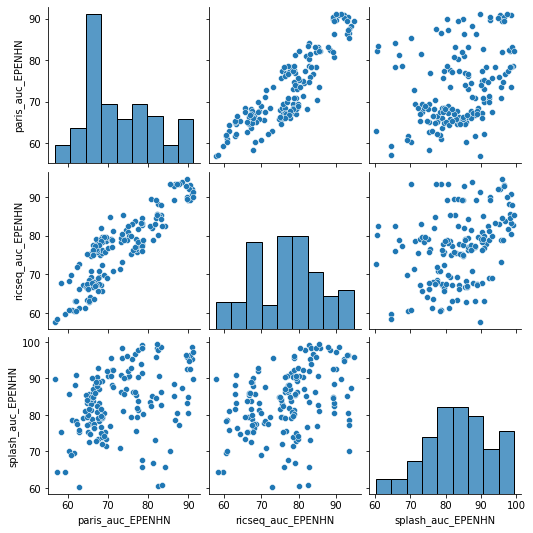

In [11]:
plot_correlation(df_full.filter(['paris_auc_EPENHN',  'ricseq_auc_EPENHN', 'splash_auc_EPENHN']))

### Correlazione tra AUC dei modelli (accuracy è simile)

splash e paris anticorrelano forte. anche paris e ricseq sembrano anticorrelare. splash e ricseq non c e correlazione.

In [12]:
#plot_correlation(df_full.filter(['paris_acc_ES', 'paris_aucINTARNA_ES', 'ricseq_acc_ES', 'splash_acc_ES']))

Correlation Matrix:
               paris_auc_ES  ricseq_auc_ES  splash_auc_ES
paris_auc_ES       1.000000      -0.359227      -0.412738
ricseq_auc_ES     -0.359227       1.000000      -0.328709
splash_auc_ES     -0.412738      -0.328709       1.000000


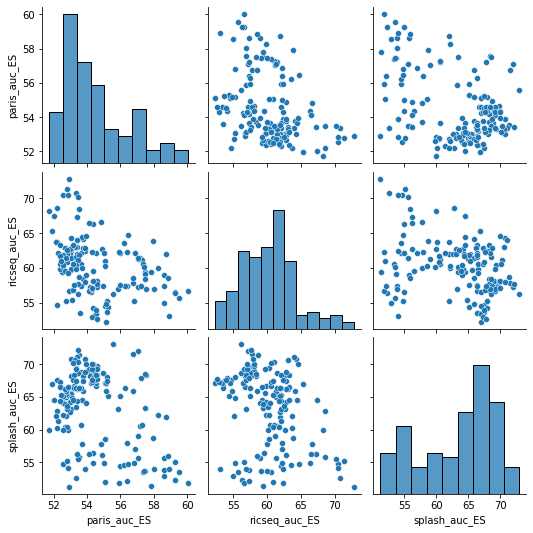

In [13]:
plot_correlation(df_full.filter(['paris_auc_ES',  'ricseq_auc_ES', 'splash_auc_ES']))

### Correlazione tra AUC di Paris e ParisHQ (>35)

Molto forte

Correlation Matrix:
                 paris_auc_ES  paris_auc_ES_HQ
paris_auc_ES         1.000000         0.873014
paris_auc_ES_HQ      0.873014         1.000000


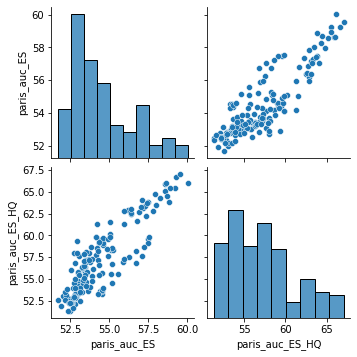

In [14]:
plot_correlation(df_full.filter(['paris_auc_ES',  'paris_auc_ES_HQ']))

### Correlazione tra AUC non-cds-cds e AUC cds-cds su paris, ricseq, splash

All'interno dei dataset sembrano essere positive le correlazioni.

Correlation Matrix:
                        splash_auc_ES_cdscds  splash_auc_ES_nocdscds
splash_auc_ES_cdscds                1.000000                0.880824
splash_auc_ES_nocdscds              0.880824                1.000000


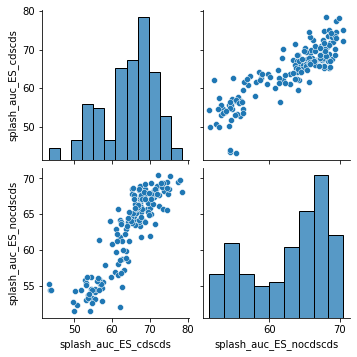

Correlation Matrix:
                       paris_auc_ES_cdscds  paris_auc_ES_nocdscds
paris_auc_ES_cdscds               1.000000               0.458045
paris_auc_ES_nocdscds             0.458045               1.000000


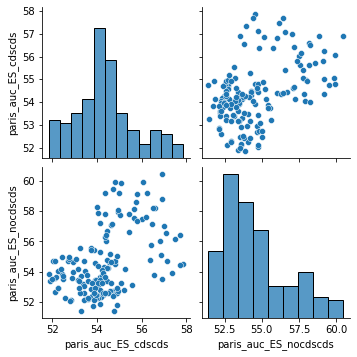

Correlation Matrix:
                        ricseq_auc_ES_cdscds  ricseq_auc_ES_nocdscds
ricseq_auc_ES_cdscds                1.000000                0.488264
ricseq_auc_ES_nocdscds              0.488264                1.000000


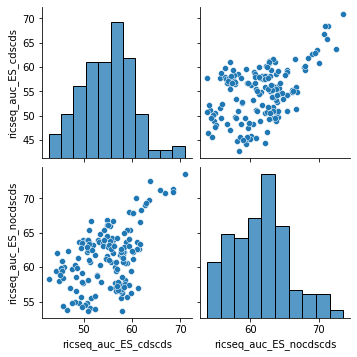

In [15]:
for m in ['splash', 'paris', 'ricseq']:
    plot_correlation(df_full.filter([f'{m}_auc_ES_cdscds', f'{m}_auc_ES_nocdscds']))

### Correlazione tra AUC non-cds-cds e AUC cds-cds tra dataset

Tra dataset le AUC cds-cds non sembrano correlare, tranne una moderata anticorrelazione tra splash e paris che comunque correlavano negativamente in modo molto forte prima. 

Le AUC noncds-cds riflettono i risultati gia visti sulle AUC globali tra i dataset

Correlation Matrix:
                      paris_auc_ES_cdscds  ricseq_auc_ES_cdscds  \
paris_auc_ES_cdscds              1.000000              -0.23955   
ricseq_auc_ES_cdscds            -0.239550               1.00000   
splash_auc_ES_cdscds            -0.460218              -0.08059   

                      splash_auc_ES_cdscds  
paris_auc_ES_cdscds              -0.460218  
ricseq_auc_ES_cdscds             -0.080590  
splash_auc_ES_cdscds              1.000000  


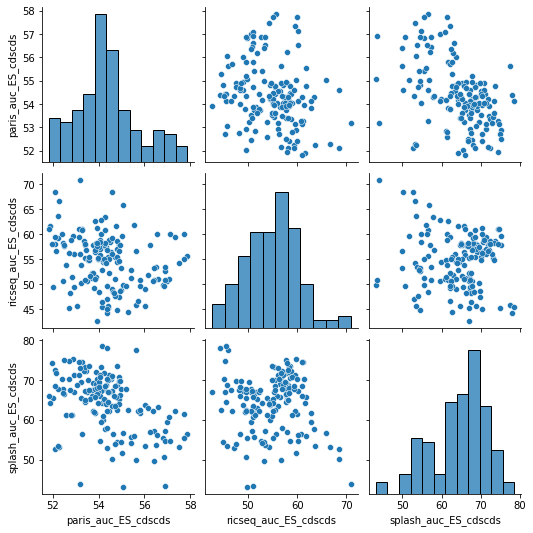

In [16]:
plot_correlation(df_full.filter(['paris_auc_ES_cdscds',  'ricseq_auc_ES_cdscds', 'splash_auc_ES_cdscds']))

Correlation Matrix:
                        paris_auc_ES_nocdscds  ricseq_auc_ES_nocdscds  \
paris_auc_ES_nocdscds                1.000000               -0.319665   
ricseq_auc_ES_nocdscds              -0.319665                1.000000   
splash_auc_ES_nocdscds              -0.380526               -0.379249   

                        splash_auc_ES_nocdscds  
paris_auc_ES_nocdscds                -0.380526  
ricseq_auc_ES_nocdscds               -0.379249  
splash_auc_ES_nocdscds                1.000000  


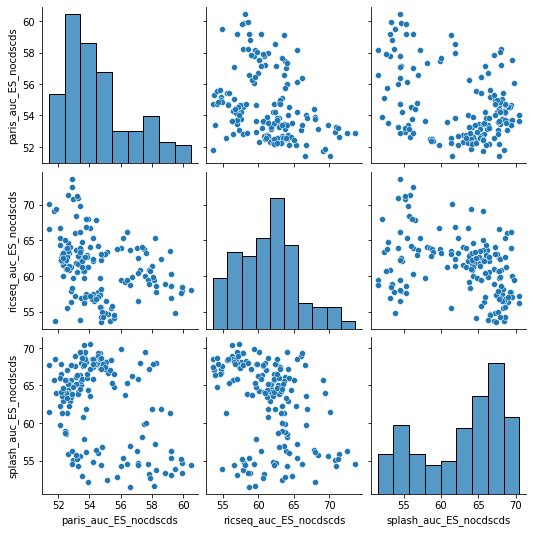

In [17]:
plot_correlation(df_full.filter(['paris_auc_ES_nocdscds',  'ricseq_auc_ES_nocdscds', 'splash_auc_ES_nocdscds']))

### Correlazione tra AUC e AUC non in train su paris, ricseq, splash

Sembra forte per paris, ricseq, meno forte ma comunque positiva per splash.

Correlation Matrix:
                       splash_auc_ES  splash_auc_ES_notrain
splash_auc_ES               1.000000               0.699125
splash_auc_ES_notrain       0.699125               1.000000


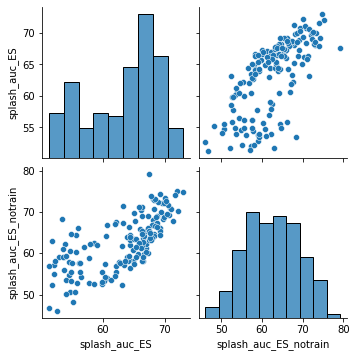

Correlation Matrix:
                      paris_auc_ES  paris_auc_ES_notrain
paris_auc_ES              1.000000              0.959867
paris_auc_ES_notrain      0.959867              1.000000


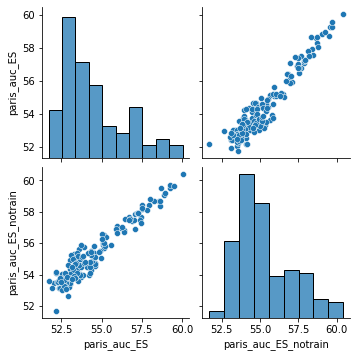

Correlation Matrix:
                       ricseq_auc_ES  ricseq_auc_ES_notrain
ricseq_auc_ES               1.000000               0.689875
ricseq_auc_ES_notrain       0.689875               1.000000


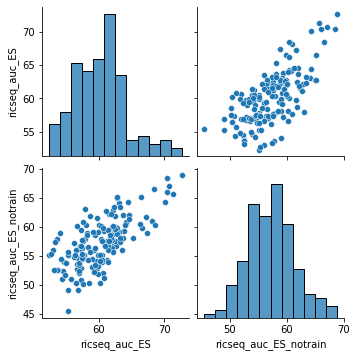

In [18]:
for m in ['splash', 'paris', 'ricseq']:
    plot_correlation(df_full.filter([f'{m}_auc_ES', f'{m}_auc_ES_notrain']))

### Correlazione tra acc su singole classi: easypos, smartneg, hardneg

Esploriamo la correlazione tra singole classi. Sui positivi, tutti correlano positivamente (0.5/0.8), e questo mi sembra un bene: un modello piu capace di prevedere un positivo su paris è piu capace anche di prevederlo su ricseq e su splash, e questo vale anche tra ricseq e splash (0.5). Sui negativi invece la correlazione è forte tra paris e ricseq (0.9) e debole tra paris e splash (0.4).

splash ha easyneg e hardneg che sono 18 sample ciascuna, quindi tipo o fa 0.5 o fa 1... non so quanto abbia senso guardare quelli.

Correlation Matrix:
                    paris_acc_easypos  ricseq_acc_easypos  splash_acc_easypos
paris_acc_easypos            1.000000            0.783437            0.789203
ricseq_acc_easypos           0.783437            1.000000            0.654455
splash_acc_easypos           0.789203            0.654455            1.000000


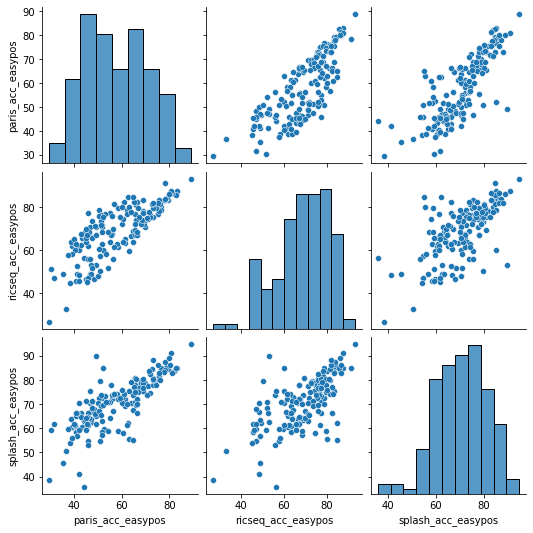

Correlation Matrix:
                     paris_acc_smartneg  ricseq_acc_smartneg  \
paris_acc_smartneg             1.000000             0.922167   
ricseq_acc_smartneg            0.922167             1.000000   
splash_acc_smartneg            0.539714             0.582081   

                     splash_acc_smartneg  
paris_acc_smartneg              0.539714  
ricseq_acc_smartneg             0.582081  
splash_acc_smartneg             1.000000  


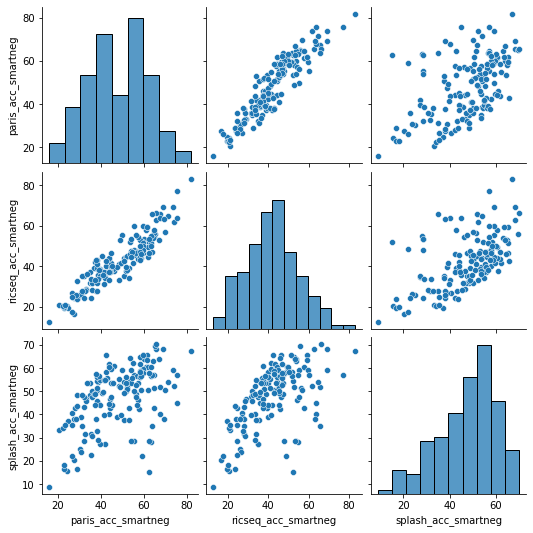

Correlation Matrix:
                    paris_acc_hardneg  ricseq_acc_hardneg  splash_acc_hardneg
paris_acc_hardneg            1.000000            0.970217            0.501949
ricseq_acc_hardneg           0.970217            1.000000            0.445351
splash_acc_hardneg           0.501949            0.445351            1.000000


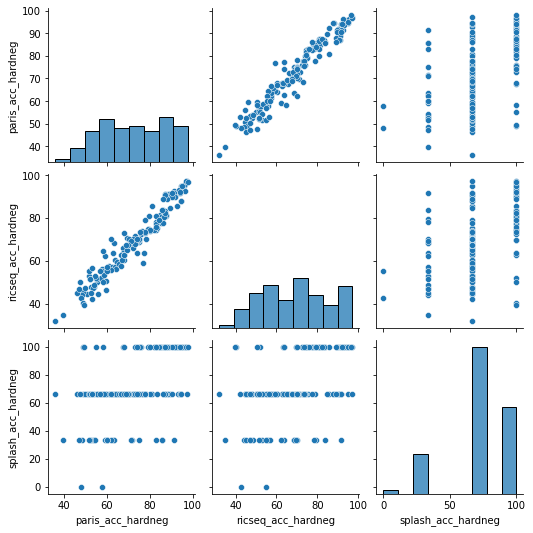

Correlation Matrix:
                    paris_acc_easyneg  ricseq_acc_easyneg  splash_acc_easyneg
paris_acc_easyneg            1.000000            0.967438            0.354601
ricseq_acc_easyneg           0.967438            1.000000            0.390082
splash_acc_easyneg           0.354601            0.390082            1.000000


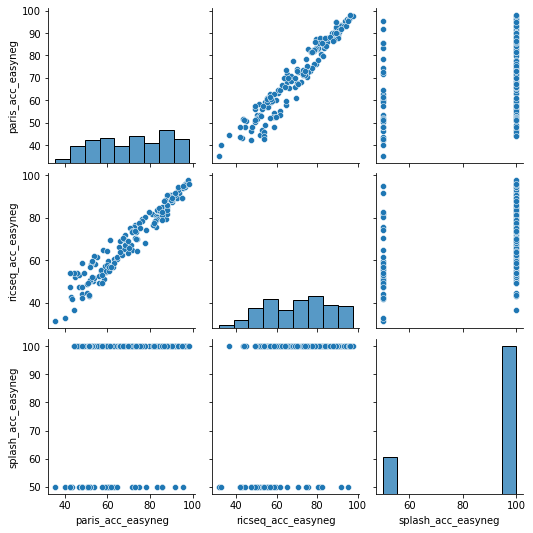

In [19]:
for d in ['easypos', 'smartneg', 'hardneg', 'easyneg']:
    plot_correlation(df_full.filter([f'paris_acc_{d}',  f'ricseq_acc_{d}', f'splash_acc_{d}']))

### Correlazione tra acc VS accEasypos, Correlazione tra acc VS accSmartneg

Le correlazioni deboli tra l'accuracy complessiva e l'accuracy delle singole classi possono indicare che l'accuracy complessiva non è una rappresentazione accurata della capacità del modello di prevedere specifiche classi. Tuttavia possiamo dire che sia per paris che per splash, la capacita di prevedere i positivi sembra proprio non correlare con l'accuracy totale, mentre la capacita di prevedere gli smartneg correla di piu (0.5). Per ricseq invece è il contrario: la capacita di prevedere i positivi sembra proprio correla leggermente con l'accuracy totale (0.5), mentre la capacita di prevedere gli smartneg non correla affatto.

Correlation Matrix:
                   paris_acc_easypos  paris_acc_ES
paris_acc_easypos           1.000000     -0.122038
paris_acc_ES               -0.122038      1.000000


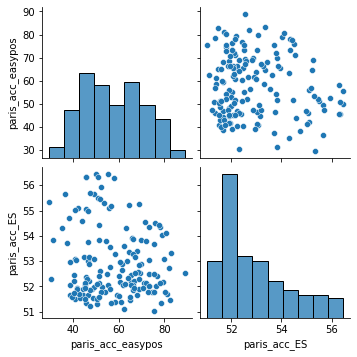

Correlation Matrix:
                    splash_acc_easypos  splash_acc_ES
splash_acc_easypos            1.000000       0.129821
splash_acc_ES                 0.129821       1.000000


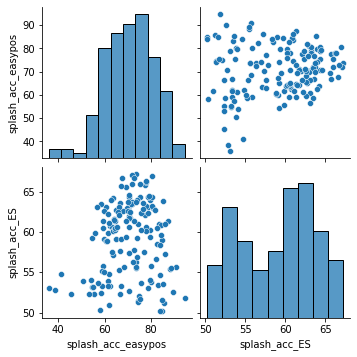

Correlation Matrix:
                    ricseq_acc_easypos  ricseq_acc_ES
ricseq_acc_easypos             1.00000        0.12407
ricseq_acc_ES                  0.12407        1.00000


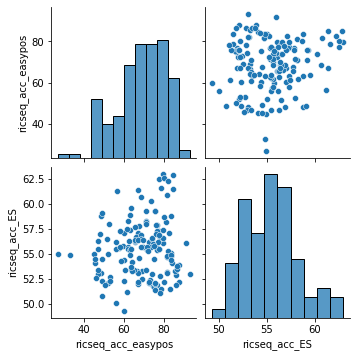

Correlation Matrix:
                    paris_acc_smartneg  paris_acc_ES
paris_acc_smartneg            1.000000      0.330453
paris_acc_ES                  0.330453      1.000000


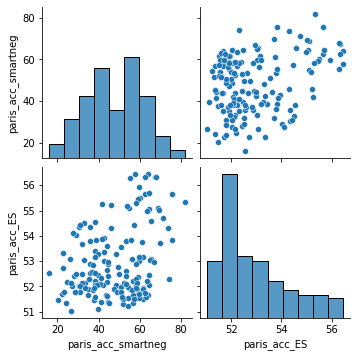

Correlation Matrix:
                     splash_acc_smartneg  splash_acc_ES
splash_acc_smartneg              1.00000        0.59852
splash_acc_ES                    0.59852        1.00000


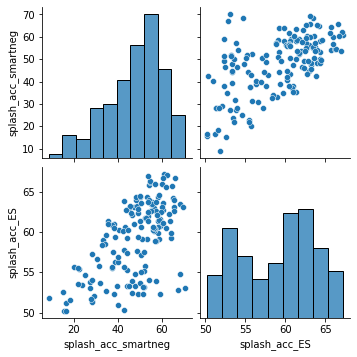

Correlation Matrix:
                     ricseq_acc_smartneg  ricseq_acc_ES
ricseq_acc_smartneg             1.000000       0.317108
ricseq_acc_ES                   0.317108       1.000000


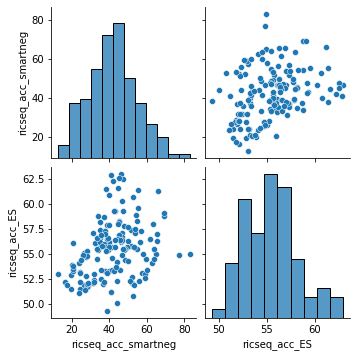

In [20]:
for d in ['easypos', 'smartneg']:
    plot_correlation(df_full.filter([f'paris_acc_{d}',  f'paris_acc_ES']))
    plot_correlation(df_full.filter([f'splash_acc_{d}',  f'splash_acc_ES']))
    plot_correlation(df_full.filter([f'ricseq_acc_{d}',  f'ricseq_acc_ES']))

### Accuracy media dei modelli su classe 1

In [21]:
for m in ['paris', 'ricseq', 'splash']:
    print(f'classe1 {m} acc:', 
          np.round(df_full[f'{m}_acc_easypos'].mean(), 2),
          ' std:',  np.round(df_full[f'{m}_acc_easypos'].std(), 2), 
         )
    
for m in ['paris', 'ricseq', 'splash']:
    print(f'classe0 {m} acc:', 
          np.round(df_full[f'{m}_acc_smartneg'].mean(), 2),
          ' std:',  np.round(df_full[f'{m}_acc_easypos'].std(), 2), 
         )

classe1 paris acc: 57.85  std: 13.38
classe1 ricseq acc: 68.84  std: 12.35
classe1 splash acc: 70.63  std: 10.54
classe0 paris acc: 47.98  std: 13.38
classe0 ricseq acc: 42.13  std: 12.35
classe0 splash acc: 47.65  std: 10.54


### Final considerations:

Nel task delle Patch paris correla fortemente con ricseq, ed è l'unica correlazione forte.

Nel task delle Interazioni invece Paris anticorrela (debolmente) con ricseq. Splash e Paris anticorrelano forte. Tra splash e ricseq non c e correlazione.

Per quanto riguarda le correlazioni tra AUC non-cds-cds e AUC cds-cds su paris, ricseq, splash sono essere positive. Quindi se un modello ha un AUC alta, ha un AUC cds-cds piu alta. Queste correlazioni sono piu forti per splash (0.8) e ricseq (0.6), e meno per paris (0.4). Quindi forse la qualita dei cds-cds su paris è piu debole rispetto a splash e ricseq. 

Esploriamo la correlazione tra singole classi. 
Esploriamo la correlazione tra singole classi. Sui positivi, tutti correlano positivamente (0.5/0.8), e questo mi sembra un bene: un modello piu capace di prevedere un positivo su paris è piu capace anche di prevederlo su ricseq e su splash, e questo vale anche tra ricseq e splash (0.5). Sui negativi invece la correlazione è forte tra paris e ricseq (0.9) e debole tra paris e splash (0.4).

In [113]:
name_map['model151']

'/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_easypretrain3_paristfinetuning14_splash0084_trainallNOricseq0164'

In [34]:
models_to_print = [f'model{i}' for i in range(115,1000)]
df_full[df_full.model.isin(models_to_print)][['model', 'paris_auc_ES', 'ricseq_auc_ES', 'splash_auc_ES']]

,model,paris_auc_ES,ricseq_auc_ES,splash_auc_ES
20,model115,54.61,57.23,69.21
21,model116,54.61,57.73,68.32
22,model117,54.21,56.48,67.06
23,model118,54.12,56.63,69.26
24,model119,54.34,58.04,69.95
26,model120,54.94,57.44,68.71
27,model121,54.27,56.98,69.23
28,model122,53.86,57.95,70.82
29,model123,53.44,57.62,72.16
30,model124,55.95,62.07,54.47


# Curve

In [128]:
n_best = 8
min_auc_on_all_dataset = 0.53
way = 5

In [129]:
plt.rcParams['figure.figsize'] = [10, 7]

In [130]:
df_auc = df_full.filter(['model', 'paris_auc_ES',  'ricseq_auc_ES', 'splash_auc_ES', 'splash_ES_NTconf7.61'])

In [131]:
df_auc['mean'] = df_auc[['model', 'paris_auc_ES', 'splash_auc_ES']].mean(axis =1)

/tmp/ipykernel_2327997/3538207256.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_auc['mean'] = df_auc[['model', 'paris_auc_ES', 'splash_auc_ES']].mean(axis =1)


In [132]:
if way == 1:
    #way1
    df_select = df_auc[(df_auc.drop('model', axis = 1) > min_auc_on_all_dataset * 100).all(axis = 1)]
    best_models = set(df_select.sort_values('mean', ascending = False).head(n_best)['model']).union(set(['INTARNA']))
elif way == 2:
    #way2
    best_paris = set(df_select.sort_values('paris_auc_ES', ascending = False).head( int(n_best) )['model'])
    best_ricseq = set(df_select.sort_values('ricseq_auc_ES', ascending = False).head( int(n_best) )['model'])
    best_splash = set(df_select.sort_values('splash_auc_ES', ascending = False).head( int(n_best) )['model'])
    best_models = ( best_paris.intersection(best_ricseq).intersection(best_splash) ).union(set(['INTARNA']))
elif way == 3:
    #way 3
    better_models = df_auc[df_auc['mean'] > df_auc[df_auc['model'] == 'INTARNA']['mean'].values[0] - 0.01]
    better_models = better_models[(better_models.drop('model', axis = 1) > min_auc_on_all_dataset * 100).all(axis = 1)]
    best_models = set(better_models.model).union(set(['INTARNA']))
elif way == 4:
    #way 4
    better_models = df_auc[df_auc['splash_auc_ES'] > df_auc[df_auc['model'] == 'INTARNA']['splash_auc_ES'].values[0]]
    better_models = better_models[(better_models.drop('model', axis = 1) > min_auc_on_all_dataset * 100).all(axis = 1)]
    best_models = set(better_models.model).union(set(['INTARNA']))
elif way == 5:
    #way 5
    better_models = df_auc[(df_auc['paris_auc_ES'] > df_auc[df_auc['model'] == 'INTARNA']['paris_auc_ES'].values[0])&
                           (df_auc['ricseq_auc_ES'] > df_auc[df_auc['model'] == 'INTARNA']['ricseq_auc_ES'].values[0])&
                           (df_auc['splash_auc_ES'] > df_auc[df_auc['model'] == 'INTARNA']['splash_auc_ES'].values[0])]
    better_models = better_models[(better_models.drop('model', axis = 1) > min_auc_on_all_dataset * 100).all(axis = 1)]
    better_models = better_models.sort_values('splash_auc_ES', ascending = False).head( int(n_best * 1.5) )
    better_models = better_models.sort_values('splash_ES_NTconf7.61', ascending = False).head( int(n_best) )
    best_models = set(better_models.model).union(set(['INTARNA']))

In [133]:
better_models

,model,paris_auc_ES,ricseq_auc_ES,splash_auc_ES,splash_ES_NTconf7.61,mean
148,model89,53.48,61.06,70.33,82.00,61.905
6,model102,55.58,56.18,73.03,77.34,64.305
5,model101,56.73,57.80,71.61,74.39,64.170
4,model100,57.08,57.25,72.02,73.25,64.550
32,model126,54.30,57.11,70.05,72.09,62.175
29,model123,53.44,57.62,72.16,71.08,62.800
158,model98,53.15,60.59,70.19,70.75,61.670
45,model138,53.02,64.21,70.72,66.08,61.870


In [134]:
orderconf = 'NTconf' # 'NTconf', 'INTARNAconf'

#ES

diz_curve = {}

for dataset in ['splash', 'ricseq', 'paris']:
    diz_dataset = {}
    for model in best_models:
        datasetlist = []
        for conf in confidence_level:
            modelrow = df_full[df_full['model'] == model]
            datasetlist.append(modelrow[f'{dataset}_ES_{orderconf}{conf}'].iloc[0])  
        diz_dataset[model] = datasetlist
    diz_curve[dataset] = diz_dataset

In [135]:
df_curve = pd.DataFrame.from_dict(diz_curve, 'index')#.reset_index().rename({'index':'dataset'}, axis = 1)

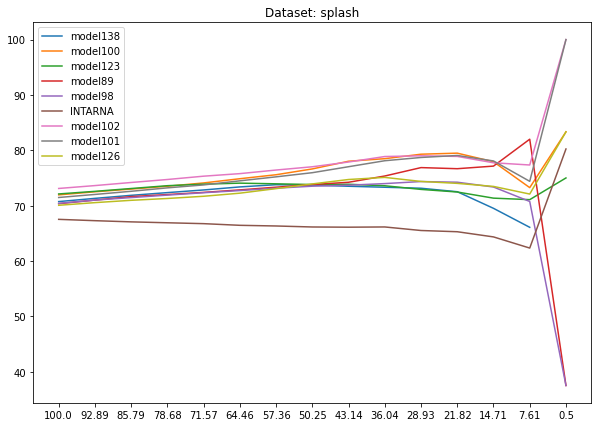

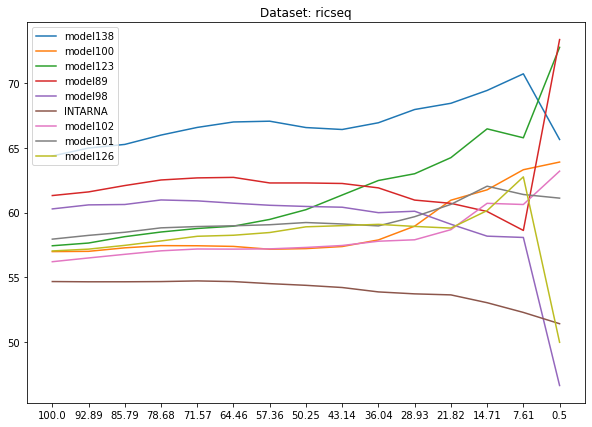

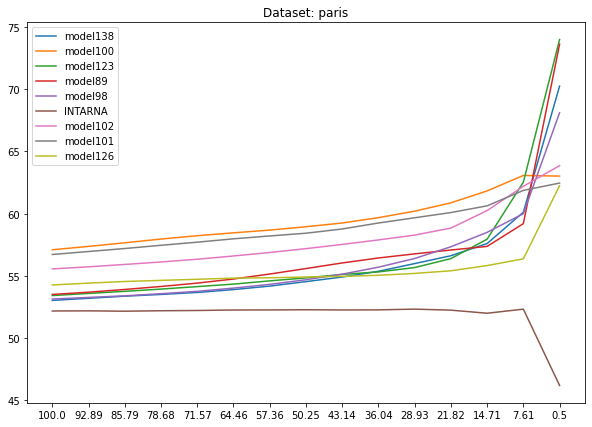

In [136]:
for dataset in ['splash', 'ricseq', 'paris']:
    row = df_curve.loc[dataset]
    for model in best_models:
        plt.plot(confidence_level, row[model], label = model)
      
    plt.title(f'Dataset: {dataset}')
    plt.legend()
    plt.show()

### Qui ordiniamo con il nostro score i nostri modelli e INTARNA con il suo

In [137]:
orderconf = 'NTconf' # 'NTconf', 'INTARNAconf'

#ES

diz_curve = {}

for dataset in ['splash', 'ricseq', 'paris']:
    diz_dataset = {}
    for model in best_models:
        datasetlist = []
        for conf in confidence_level:
            modelrow = df_full[df_full['model'] == model]
            if model == 'INTARNA':
                orderconf = 'INTARNAconf'
            else:
                orderconf = 'NTconf'
            datasetlist.append(modelrow[f'{dataset}_ES_{orderconf}{conf}'].iloc[0])  
        diz_dataset[model] = datasetlist
    diz_curve[dataset] = diz_dataset

In [138]:
df_curve = pd.DataFrame.from_dict(diz_curve, 'index')#.reset_index().rename({'index':'dataset'}, axis = 1)

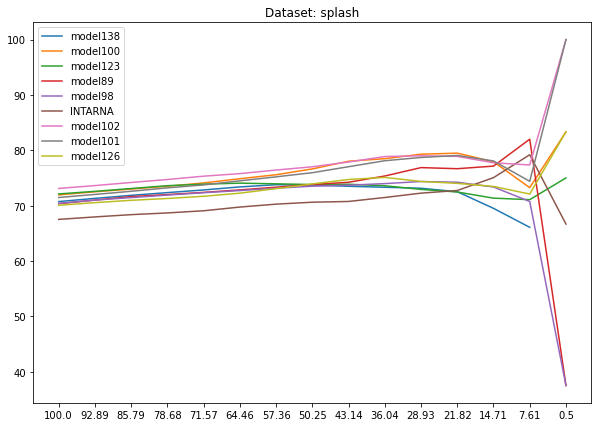

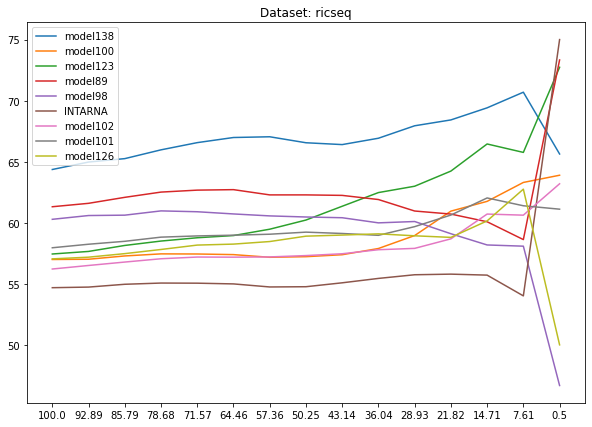

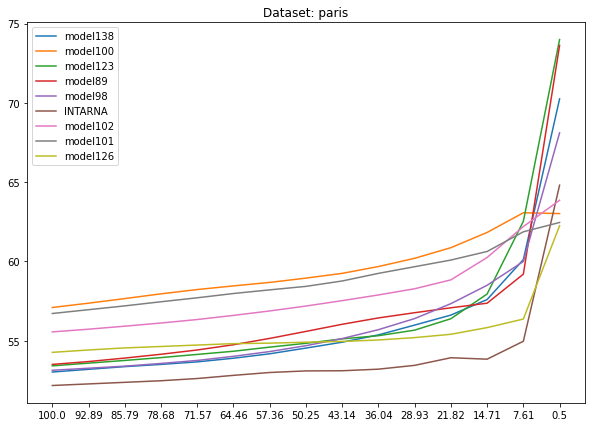

In [139]:
for dataset in ['splash', 'ricseq', 'paris']:
    row = df_curve.loc[dataset]
    for model in best_models:
        plt.plot(confidence_level, row[model], label = model)
      
    plt.title(f'Dataset: {dataset}')
    plt.legend()
    plt.show()

In [51]:
models_selected = ['model95', 'model99', 'model100', 'model101', 'model102', 'model131']

In [52]:
for i in models_selected:
    print(name_map[i])

/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151_trainall0162
/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151_trainall0161
/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151_trainall0198
/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151_trainall0199
/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151_trainallBEST
/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_trainall0051


In [51]:
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch1_paristfinetuningSPLASHval25_ricseqSPLASHval28_splash103
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch1_easypretrain10_paristfinetuningSPLASHval29_ricseqSPLASHval60_splashRICSEQval110
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch1_paristfinetuningSPLASHval25_ricseqSPLASHval28_splashBEST
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151


In [52]:
columns_to_print = ['model', 
                    'paris_auc_ES', 'paris_auc_EPENHN',
                    'ricseq_auc_ES', 'ricseq_auc_EPENHN',
                    'splash_auc_ES', 'splash_auc_EPENHN']

In [53]:
df_full[df_full['model'].isin(models_selected)|(df_full['model']=='INTARNA')].filter(columns_to_print, axis = 1).round(2)

,model,paris_auc_ES,paris_auc_EPENHN,ricseq_auc_ES,ricseq_auc_EPENHN,splash_auc_ES,splash_auc_EPENHN
0,INTARNA,52.18,56.86,54.77,57.72,67.52,90.12
14,model20,53.21,69.37,60.59,75.85,66.60,75.20
40,model44,52.41,65.80,60.54,75.30,67.28,84.48
42,model46,53.13,68.21,56.86,67.21,67.57,81.76
43,model47,53.36,70.90,60.86,77.07,67.46,88.16


### Correlation between ricsecTest VS ricseq, splashTest VS splash

Sembra esserci una correlazione abbastanza forte, quindi posso utilizzare i dati di test per fare tutte le altre analisi.

In [28]:
only_test = False
df_full_F, name_map_F, confidence_level = otain_results(checkpoint_dir_paths, space, n_values, MIN_PERC, only_test)

  0%|          | 0/33 [00:00<?, ?it/s]

In [119]:
ok_ricseq = [ os.path.join(chkpt_folder, i) for i in [
    'all_modelarch2_easypretrain3_paristfinetuningSPLASHval8', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval29', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval30',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval20',
             'all_modelarch1_easypretrain7_paristrain22', 
             'all_modelarch1_easypretrain7_paristrain12_trainhq',
             'all_modelarch2_easypretrain3_paristfinetuning13',
             'all_modelarch2_easypretrain3_paristfinetuning14', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval12'
]]



ok_splash = [os.path.join(chkpt_folder, i) for i in [
    'all_modelarch2_easypretrain3_paristfinetuningSPLASHval8', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval29', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval30',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval20',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval18_ricseqSPLASHvalBEST',
             'all_modelarch1_easypretrain7_paristrain22',
             'all_modelarch1_easypretrain7_paristrain12_trainhq',
             'all_modelarch2_easypretrain3_paristfinetuning13',
             'all_modelarch2_easypretrain3_paristfinetuning14',
             'all_modelarch2_easypretrain3_paristfinetuning14_ricseq20',
             'all_modelarch2_easypretrain3_paristfinetuning14_ricseq23',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval18',
             'all_modelarch1_paristfinetuningSPLASHval25_ricseqSPLASHval28',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval12',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval18_ricseqSPLASHval20',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval29_ricseqSPLASHvalBEST'
]]

In [120]:
map_splash = {}
for i in ok_splash:
    for j in name_map.keys():
        if name_map[j] == i:
            name_map_splash = j
    for j in name_map_F.keys():
        if name_map[j] == i:
            name_map_splash_F = j
    map_splash[name_map_splash] = name_map_splash_F

map_splash = pd.DataFrame.from_dict(map_splash, 'index').reset_index().rename({'index':'name_map', 0:'name_map_F'}, axis = 1)
    
map_ricseq = {}
for i in ok_ricseq:
    for j in name_map.keys():
        if name_map[j] == i:
            name_map_ricseq = j
    for j in name_map_F.keys():
        if name_map[j] == i:
            name_map_ricseq_F = j
    map_ricseq[name_map_ricseq] = name_map_ricseq_F
    
map_ricseq = pd.DataFrame.from_dict(map_ricseq, 'index').reset_index().rename({'index':'name_map', 0:'name_map_F'}, axis = 1)


In [121]:
#assert we dont have to change names of the dataframes, otherwise we have to modify the names, I didnt implement this case
if ((map_ricseq.name_map == map_ricseq.name_map_F).all()) & ((map_splash.name_map == map_splash.name_map_F).all()):
    pass
else:
    raise NotImplementedError

In [122]:
df_ricseq = df_full[df_full['model'].isin(set(map_ricseq['name_map']))][['model', 'ricseq_auc_ES']]
df_ricseq_F = df_full_F[df_full_F['model'].isin(set(map_ricseq['name_map']))][['model', 'ricseq_auc_ES']]

df_splash = df_full[df_full['model'].isin(set(map_splash['name_map']))][['model', 'splash_auc_ES']]
df_splash_F = df_full_F[df_full_F['model'].isin(set(map_splash['name_map']))][['model', 'splash_auc_ES']]

In [123]:
df_ricseq = df_ricseq.merge(df_ricseq_F, on = 'model').drop('model', axis = 1).rename(
    {'ricseq_auc_ES_x':'ricseq_auc_ES_Test', 
    'ricseq_auc_ES_y':'ricseq_auc_ES_Full'}, axis = 1)

df_splash = df_splash.merge(df_splash_F, on = 'model').drop('model', axis = 1).rename(
    {'splash_auc_ES_x':'splash_auc_ES_Test', 
    'splash_auc_ES_y':'splash_auc_ES_Full'}, axis = 1)

Correlation Matrix:
                    ricseq_auc_ES_Test  ricseq_auc_ES_Full
ricseq_auc_ES_Test            1.000000            0.986051
ricseq_auc_ES_Full            0.986051            1.000000


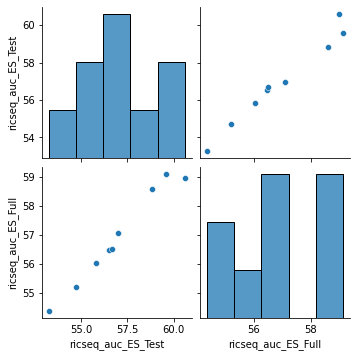

In [124]:
plot_correlation(df_ricseq)

Correlation Matrix:
                    splash_auc_ES_Test  splash_auc_ES_Full
splash_auc_ES_Test            1.000000            0.762477
splash_auc_ES_Full            0.762477            1.000000


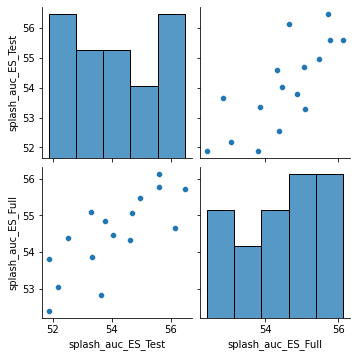

In [125]:
plot_correlation(df_splash)